In [1]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import cv2
import numpy as np
from scipy.ndimage import median_filter
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt

KeyboardInterrupt: 

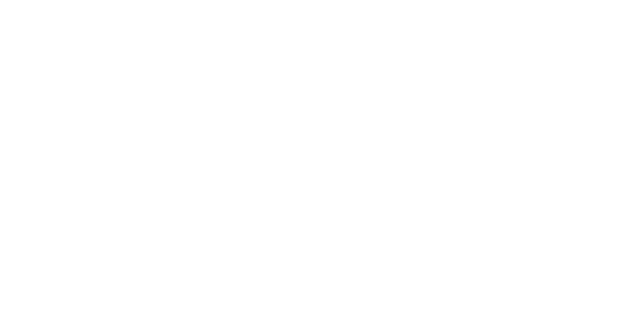

In [ ]:

class NoiseRemovalApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Image Noise Removal Tool")
        self.root.geometry("1000x600")
        self.root.configure(bg="#f2f2f2")

        self.image = None
        self.processed_image = None

        # ====== Buttons ======
        btn_frame = tk.Frame(root, bg="#f2f2f2")
        btn_frame.pack(pady=10)

        tk.Button(btn_frame, text="📁 Open Image", command=self.open_image, width=20, bg="#007acc", fg="white").grid(row=0, column=0, padx=10)
        tk.Button(btn_frame, text="🧹 Remove Salt & Pepper", command=self.remove_salt_pepper, width=20, bg="#28a745", fg="white").grid(row=0, column=1, padx=10)
        tk.Button(btn_frame, text="⚙️ Remove Periodic Noise (FFT)", command=self.remove_periodic_noise, width=25, bg="#ffc107", fg="black").grid(row=0, column=2, padx=10)

        # ====== Image display area ======
        self.fig, self.axes = plt.subplots(1, 2, figsize=(8, 4))
        for ax in self.axes:
            ax.axis("off")

        self.canvas = FigureCanvasTkAgg(self.fig, master=root)
        self.canvas.get_tk_widget().pack()

    # ========== Function to open image ==========
    def open_image(self):
        file_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpg *.png *.jpeg *.bmp")])
        if file_path:
            self.image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            self.processed_image = self.image.copy()
            self.display_images()
        else:
            messagebox.showwarning("Warning", "No image selected!")

    # ========== Display original and processed images ==========
    def display_images(self):
        self.axes[0].imshow(self.image, cmap="gray")
        self.axes[0].set_title("Original Image")

        if self.processed_image is not None:
            self.axes[1].imshow(self.processed_image, cmap="gray")
            self.axes[1].set_title("Processed Image")

        self.canvas.draw()

    # ========== Remove Salt & Pepper Noise using Median Filter ==========
    def remove_salt_pepper(self):
        if self.image is None:
            messagebox.showerror("Error", "Please load an image first!")
            return

        self.processed_image = median_filter(self.image, size=3)
        self.display_images()
        messagebox.showinfo("Done", "Salt & Pepper noise removed successfully!")

    # ========== Remove Periodic Noise using FFT ==========
    def remove_periodic_noise(self):
        if self.image is None:
            messagebox.showerror("Error", "Please load an image first!")
            return

        f = np.fft.fft2(self.image)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = np.log(1 + np.abs(fshift))

        rows, cols = self.image.shape
        crow, ccol = rows // 2, cols // 2

        mask = np.zeros((rows, cols), np.uint8)
        r = 50  
        center = [crow, ccol]
        y, x = np.ogrid[:rows, :cols]
        mask_area = (x - center[1]) ** 2 + (y - center[0]) ** 2 <= r * r
        mask[mask_area] = 1

        fshift_filtered = fshift * mask

        f_ishift = np.fft.ifftshift(fshift_filtered)
        img_back = np.fft.ifft2(f_ishift)
        img_back = np.abs(img_back)

        self.processed_image = np.uint8(np.clip(img_back, 0, 255))
        self.display_images()
        messagebox.showinfo("Done", "Periodic noise removed successfully!")


# ========== Run the App ==========
if __name__ == "__main__":
    root = tk.Tk()
    app = NoiseRemovalApp(root)
    root.mainloop()
